### MLP + BiLSTM 为基模型，Transformer 为元模型

In [30]:
# 修改后的代码：MLP + BiLSTM 为基模型，Transformer 为元模型

import os
import math
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ============================================================
# 1. 固定所有随机种子（最重要！）
# ============================================================
def set_seed(seed=42):
    """固定所有随机种子，确保可复现"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# 清理GPU内存
torch.cuda.empty_cache()
gc.collect()

# ============================================================
# 2. 加载数据
# ============================================================
os.chdir('G:\lhy\work')

X_new=pd.read_csv(r'G:\\lhy\work\\train_feature\\feature\\ESMC300+PAAC+APAAC.csv',header=None)
y_new= pd.read_csv(r'data/label_train.csv',header=None)

X_new1=pd.read_csv(r"G:\lhy\work\test_feature\ESMC300+PAAC+APAAC.csv",header=None)
y_new1= pd.read_csv(r'data/label_test.csv',header=None)

X_train = np.array(X_new)
y_train = np.array(y_new).ravel()
X_test = np.array(X_new1)
y_test = np.array(y_new1).ravel()

# ============================================================
# 3. 特征标准化（关键！）
# ============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"训练集: {X_train.shape}")
print(f"测试集: {X_test.shape}")
print(f"特征范围: [{X_train.min():.2f}, {X_train.max():.2f}]")

input_dim = X_train.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"设备: {device}")

# ============================================================
# 4. 简单 MLP 模型（基模型）- 已修复
# ============================================================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64), output_dim=2, dropout=0.3, use_bn=False):
        """
        Args:
            input_dim: 输入特征维度
            hidden_dims: 隐藏层维度，可以是 int 或 tuple
            output_dim: 输出类别数（二分类用2）
            dropout: dropout 比例
            use_bn: 是否使用 BatchNorm（建议 False，用 LayerNorm）
        """
        super().__init__()
        self.use_bn = use_bn
        
        # 统一处理 hidden_dims
        if isinstance(hidden_dims, int):
            hidden_dims = (hidden_dims,)
        
        layers = []
        prev_dim = input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_bn:
                layers.append(nn.LayerNorm(h_dim))  # 用 LayerNorm 替代 BatchNorm
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ============================================================
# 5. BiLSTM 模型（基模型）
# ============================================================
class BiLSTMWithSimpleAttention(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.3):
        super().__init__()
        
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        self.input_proj = nn.Sequential(
            nn.Linear(in_dim, seq_len * hidden_dim),
            nn.LayerNorm(seq_len * hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        
        self.ln1 = nn.LayerNorm(hidden_dim * 2)
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden_dim * 2)
        
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim * 2)
        )
        self.ln3 = nn.LayerNorm(hidden_dim * 2)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 2)  # 输出2个类别
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.input_proj(x)
        x = x.view(batch_size, self.seq_len, self.hidden_dim)
        
        lstm_out, (h_n, _) = self.bilstm(x)
        
        forward_hidden = h_n[-2, :, :]
        backward_hidden = h_n[-1, :, :]
        hidden = torch.cat([forward_hidden, backward_hidden], dim=1)
        
        hidden = self.ln1(hidden)
        hidden = hidden.unsqueeze(1)
        
        attn_out, _ = self.self_attention(hidden, hidden, hidden)
        hidden = self.ln2(hidden + attn_out)
        
        hidden = self.ln3(hidden + self.ffn(hidden))
        hidden = hidden.squeeze(1)
        
        return self.classifier(hidden)

# ============================================================
# 6. Transformer 元模型
# ============================================================
class TorchTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, num_heads=4, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=num_heads,
            dropout=dropout, batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 2)  # 输出2个类别
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.ln1(self.input_proj(x))
        x = x.unsqueeze(1)
        attn_out, _ = self.attention(x, x, x)
        x = self.ln2(x + attn_out)
        x = self.ln3(x + self.ffn(x))
        x = x.squeeze(1)
        return self.classifier(x)

# ============================================================
# 7. MLP 分类器（基模型）- 已修复
# ============================================================
class TorchMLPClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, in_dim, hidden_dim=128, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        
        # 划分验证集
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        # DataLoader
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)  # CrossEntropyLoss 需要 long
        )
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            worker_init_fn=lambda _: set_seed(self.random_state)
        )
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        # 模型 - 修复参数传递
        self.model = SimpleMLP(
            input_dim=self.in_dim,
            hidden_dims=(self.hidden_dim, self.hidden_dim // 2),  # (128, 64)
            output_dim=2,  # 二分类
            dropout=self.dropout,
            use_bn=False  # 关闭 BatchNorm
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        # 早停
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training MLP...")
        
        for epoch in range(self.epochs):
            # 训练
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)  # shape: (batch, 2)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            # 验证
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            # 早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        # 恢复最佳模型
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ MLP done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)  # (batch, 2)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def decision_function(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 8. BiLSTM 分类器（基模型）- 已修复
# ============================================================
class TorchBiLSTMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, in_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        
        # 划分验证集
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        # DataLoader
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)  # CrossEntropyLoss 需要 long
        )
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            worker_init_fn=lambda _: set_seed(self.random_state)
        )
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        # 模型
        self.model = BiLSTMWithSimpleAttention(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            seq_len=self.seq_len,
            num_heads=self.num_heads,
            dropout=self.dropout
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        # 早停
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training BiLSTM...")
        
        for epoch in range(self.epochs):
            # 训练
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)  # (batch, 2)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            # 验证
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            # 早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        # 恢复最佳模型
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ BiLSTM done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)  # (batch, 2)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def decision_function(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 9. Transformer 元模型分类器 - 已修复
# ============================================================
class TorchTransformerMetaClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, hidden_dim=32, num_heads=4, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.in_dim = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        self.in_dim = X.shape[1]
        
        # 划分验证集
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        # DataLoader
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)  # CrossEntropyLoss 需要 long
        )
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        # 模型
        self.model = TorchTransformer(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            num_heads=self.num_heads,
            dropout=self.dropout
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        # 早停
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training Transformer Meta Model...")
        
        for epoch in range(self.epochs):
            # 训练
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)  # (batch, 2)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            # 验证
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            # 早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        # 恢复最佳模型
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ Transformer Meta done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)  # (batch, 2)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# ============================================================
# 10. WithDecision 包装器
# ============================================================
class WithDecision(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        self.classes_ = self.estimator.classes_
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def decision_function(self, X):
        proba = self.estimator.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 11. 创建模型
# ============================================================
print("=" * 60)
print("初始化稳定版模型...")
print("=" * 60)
print("基模型: MLP + BiLSTM")
print("元模型: Transformer")
print("=" * 60)
print()

base_models = [
    # ⭐ MLP 为基模型 1
    ('mlp', WithDecision(TorchMLPClassifier(
        in_dim=input_dim,
        hidden_dim=128,
        dropout=0.3,
        epochs=200,
        lr=5e-4,
        batch_size=32,
        patience=30,
        verbose=True,
        random_state=42
    )))
    ,
    
    # ⭐ BiLSTM 为基模型 2
    ('bilstm', WithDecision(TorchBiLSTMClassifier(
        in_dim=input_dim,
        hidden_dim=64,
        seq_len=10,
        num_heads=4,
        dropout=0.5,
        epochs=200,
        lr=5e-4,
        batch_size=32,
        patience=30,
        verbose=True,
        random_state=42
    )))
]

# ⭐ Transformer 为元模型
meta_model = TorchTransformerMetaClassifier(
    hidden_dim=32,
    num_heads=4,
    dropout=0.3,
    epochs=200,
    lr=5e-4,
    batch_size=32,
    patience=30,
    verbose=True,
    random_state=42
)

# ============================================================
# 12. Stacking
# ============================================================
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    stack_method='predict_proba',  # 用概率而不是decision_function
    cv=5  # 5折交叉验证
)

# ============================================================
# 13. 训练
# ============================================================
print("\n" + "=" * 60)
print("训练 Stacking 模型...")
print("=" * 60 + "\n")

stacking_model.fit(X_train, y_train)

# ============================================================
# 14. 评估
# ============================================================
print("\n" + "=" * 60)
print("在独立测试集上评估...")
print("=" * 60 + "\n")

y_test_pred_proba = stacking_model.predict_proba(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

print(y_test_pred_proba)
import pandas as pd

# 1. 将 numpy 数组转换为 DataFrame
# columns=['Label'] 定义了csv文件头的名称，你可以改成 'Predicted' 或其他名字
# df_result = pd.DataFrame(y_test_pred_proba[:1], columns=['Label'])
df_result = pd.DataFrame(y_test_pred_proba[:, 1], columns=['Label'])


# 2. 保存为 CSV
# index=False 代表不保存行号（0, 1, 2...）
df_result.to_csv(r'G:\lhy\work\case study\final\DeepPIP\prediction_results.csv', index=False)

# print("保存成功！文件名为 prediction_results.csv")

TN, FP, FN, TP = confusion_matrix(y_test, y_test_pred).ravel()

test_accuracy = (TP + TN) / (TP + TN + FP + FN)
test_sensitivity = TP / (TP + FN)
test_specificity = TN / (TN + FP)
test_mcc = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) + 1e-10)
test_auc = roc_auc_score(y_test, y_test_pred_proba[:, 1])

print("=" * 60)
print("📊 独立测试集性能")
print("=" * 60)
print(f"Accuracy:    {test_accuracy:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"MCC:         {test_mcc:.4f}")
print(f"AUC:         {test_auc:.4f}")
# print("=" * 60)


# # ============================================================
# # 15. 输出混淆矩阵
# # ============================================================
# print("=" * 60)
# print("📊 混淆矩阵 (Confusion Matrix)")
# print("=" * 60)
# print(f"\n预测结果 vs 真实标签:\n")
# print(f"                 预测负类(0)    预测正类(1)")
# print(f"真实负类(0)        {TN:^10}    {FP:^10}")
# print(f"真实正类(1)        {FN:^10}    {TP:^10}")
# print()
# print(f"详细数值:")
# print(f"  TN (真负例): {TN}")
# print(f"  FP (假正例): {FP}")
# print(f"  FN (假负例): {FN}")
# print(f"  TP (真正例): {TP}")
# print("=" * 60)


cm = confusion_matrix(y_test, y_test_pred)
# TN, FP, FN, TP = cm.ravel()
# # 可视化混淆矩阵（可选）
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8, 6),dpi=300)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['负类 (0)', '正类 (1)'],
#             yticklabels=['负类 (0)', '正类 (1)'], m                                      
#             annot_kws={'size': 16})
# plt.xlabel('预测标签', fontsize=12)
# plt.ylabel('真实标签', fontsize=12)
# plt.title('Stacking 集成模型 - 混淆矩阵', fontsize=14)
# plt.tight_layout()
# # plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
# plt.show()
# print("\n✅ 混淆矩阵已保存为 'confusion_matrix.png'")

# print("\n" + "=" * 60)
# print("📊 独立测试集性能")
# print("=" * 60)
# print(f"Accuracy:    {test_accuracy:.4f}")
# print(f"Sensitivity: {test_sensitivity:.4f}")
# print(f"Specificity: {test_specificity:.4f}")
# print(f"MCC:         {test_mcc:.4f}")
# print(f"AUC:         {test_auc:.4f}")
# print("=" * 60)

训练集: (2872, 1009)
测试集: (342, 1009)
特征范围: [-9.25, 18.80]
设备: cuda
初始化稳定版模型...
基模型: MLP + BiLSTM
元模型: Transformer


训练 Stacking 模型...

🔧 Training MLP...
   Early stopping at epoch 37, best val_loss: 0.5911
✅ MLP done! Best val_loss: 0.5911

🔧 Training BiLSTM...
   Early stopping at epoch 38, best val_loss: 0.5947
✅ BiLSTM done! Best val_loss: 0.5947

🔧 Training MLP...
   Early stopping at epoch 33, best val_loss: 0.5805
✅ MLP done! Best val_loss: 0.5805

🔧 Training MLP...
   Early stopping at epoch 33, best val_loss: 0.6140
✅ MLP done! Best val_loss: 0.6140

🔧 Training MLP...
   Early stopping at epoch 32, best val_loss: 0.6284
✅ MLP done! Best val_loss: 0.6284

🔧 Training MLP...
   Early stopping at epoch 35, best val_loss: 0.5830
✅ MLP done! Best val_loss: 0.5830

🔧 Training MLP...
   Early stopping at epoch 33, best val_loss: 0.5932
✅ MLP done! Best val_loss: 0.5932

🔧 Training BiLSTM...
   Early stopping at epoch 34, best val_loss: 0.5936
✅ BiLSTM done! Best val_loss: 0.5936

🔧 Train

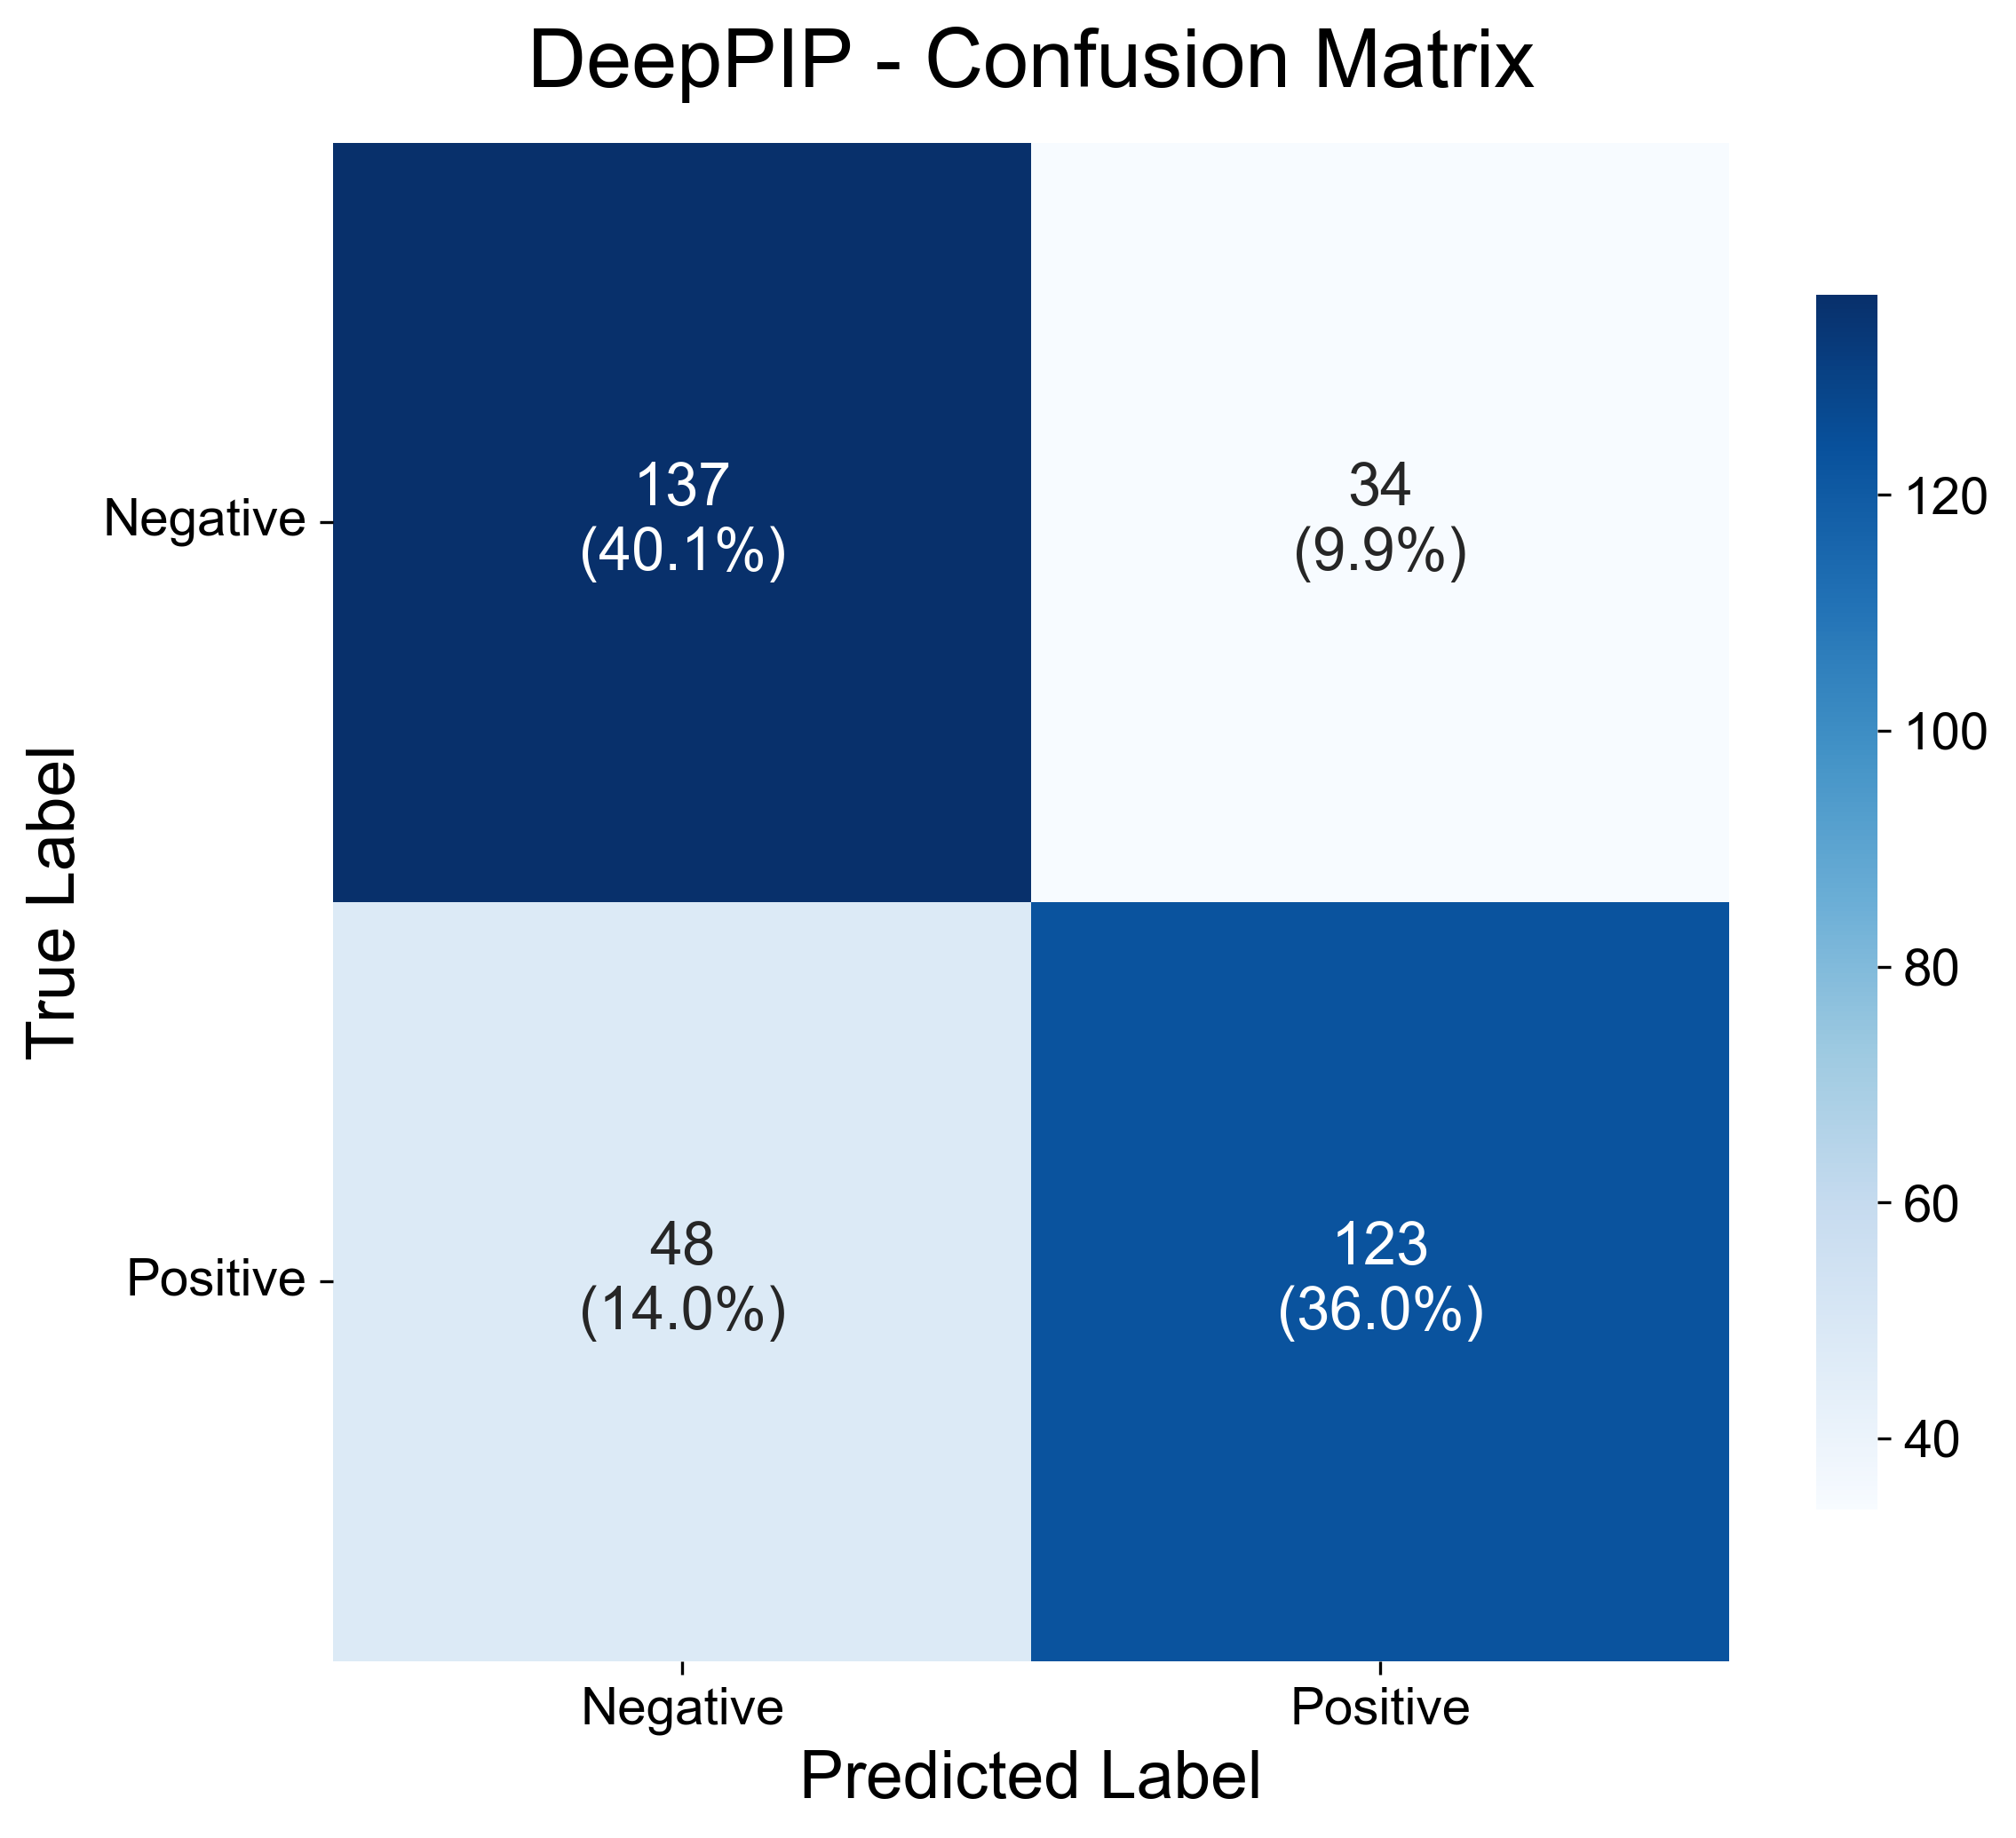


✅ 混淆矩阵已保存:
   - confusion_matrix.png
   - confusion_matrix.pdf

📊 独立测试集性能
Accuracy:    0.7602
Sensitivity: 0.7193
Specificity: 0.8012
MCC:         0.5222
AUC:         0.8080


In [28]:
# ============================================================
# 可视化混淆矩阵（修改版）
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, class_names=['Negative (0)', 'Positive (1)'], 
                          title='Confusion Matrix',
                          title_fontsize=16,
                          label_fontsize=14,
                          tick_fontsize=12,
                          annot_fontsize=20,
                          percent_fontsize=14,
                          figsize=(8, 7),
                          save_name='confusion_matrix'):
       
    # 设置全局字体为 Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.rm'] = 'Arial'
    
    # 计算百分比
    cm_sum = cm.sum()
    cm_percent = cm / cm_sum * 100
    
    # 创建标注文本（数值 + 百分比）
    annot_text = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot_text[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    # 创建图形
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    
    # 绘制热力图
    sns.heatmap(cm, annot=annot_text, fmt='', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={'size': annot_fontsize, 'fontfamily': 'Arial'},
                cbar_kws={'shrink': 0.8},
                ax=ax)
    
    # 设置颜色条字体
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=tick_fontsize)
    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
    
    # 设置坐标轴标签
    ax.set_xlabel('Predicted Label', fontsize=label_fontsize, fontname='Arial')
    ax.set_ylabel('True Label', fontsize=label_fontsize, fontname='Arial')
    
    # 设置标题
    ax.set_title(title, fontsize=title_fontsize, fontname='Arial',  pad=15)
    
    # 设置刻度标签字体
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_fontsize, fontname='Arial')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_fontsize, fontname='Arial', rotation=0)
    
    plt.tight_layout()
    
    # 保存图形
    # plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    # plt.savefig(f'{save_name}.pdf', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    
    print(f"\n✅ 混淆矩阵已保存:")
    print(f"   - {save_name}.png")
    print(f"   - {save_name}.pdf")


# 调用绘图函数
plot_confusion_matrix(
    cm,
    class_names=['Negative', 'Positive'],
    title='DeepPIP - Confusion Matrix',
    # title=r'BiLSTM$^a$+Transformer - Confusion Matrix',
    title_fontsize=22,       # 标题字体大小
    label_fontsize=18,       # 坐标轴标签字体大小
    tick_fontsize=14,        # 刻度标签字体大小
    annot_fontsize=16,       # 数值字体大小
    percent_fontsize=16,     # 百分比字体大小（包含在annot中）
    figsize=(8, 7),
    save_name='confusion_matrix'
)

print("\n" + "=" * 60)
print("📊 独立测试集性能")
print("=" * 60)
print(f"Accuracy:    {test_accuracy:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"MCC:         {test_mcc:.4f}")
print(f"AUC:         {test_auc:.4f}")
print("=" * 60)

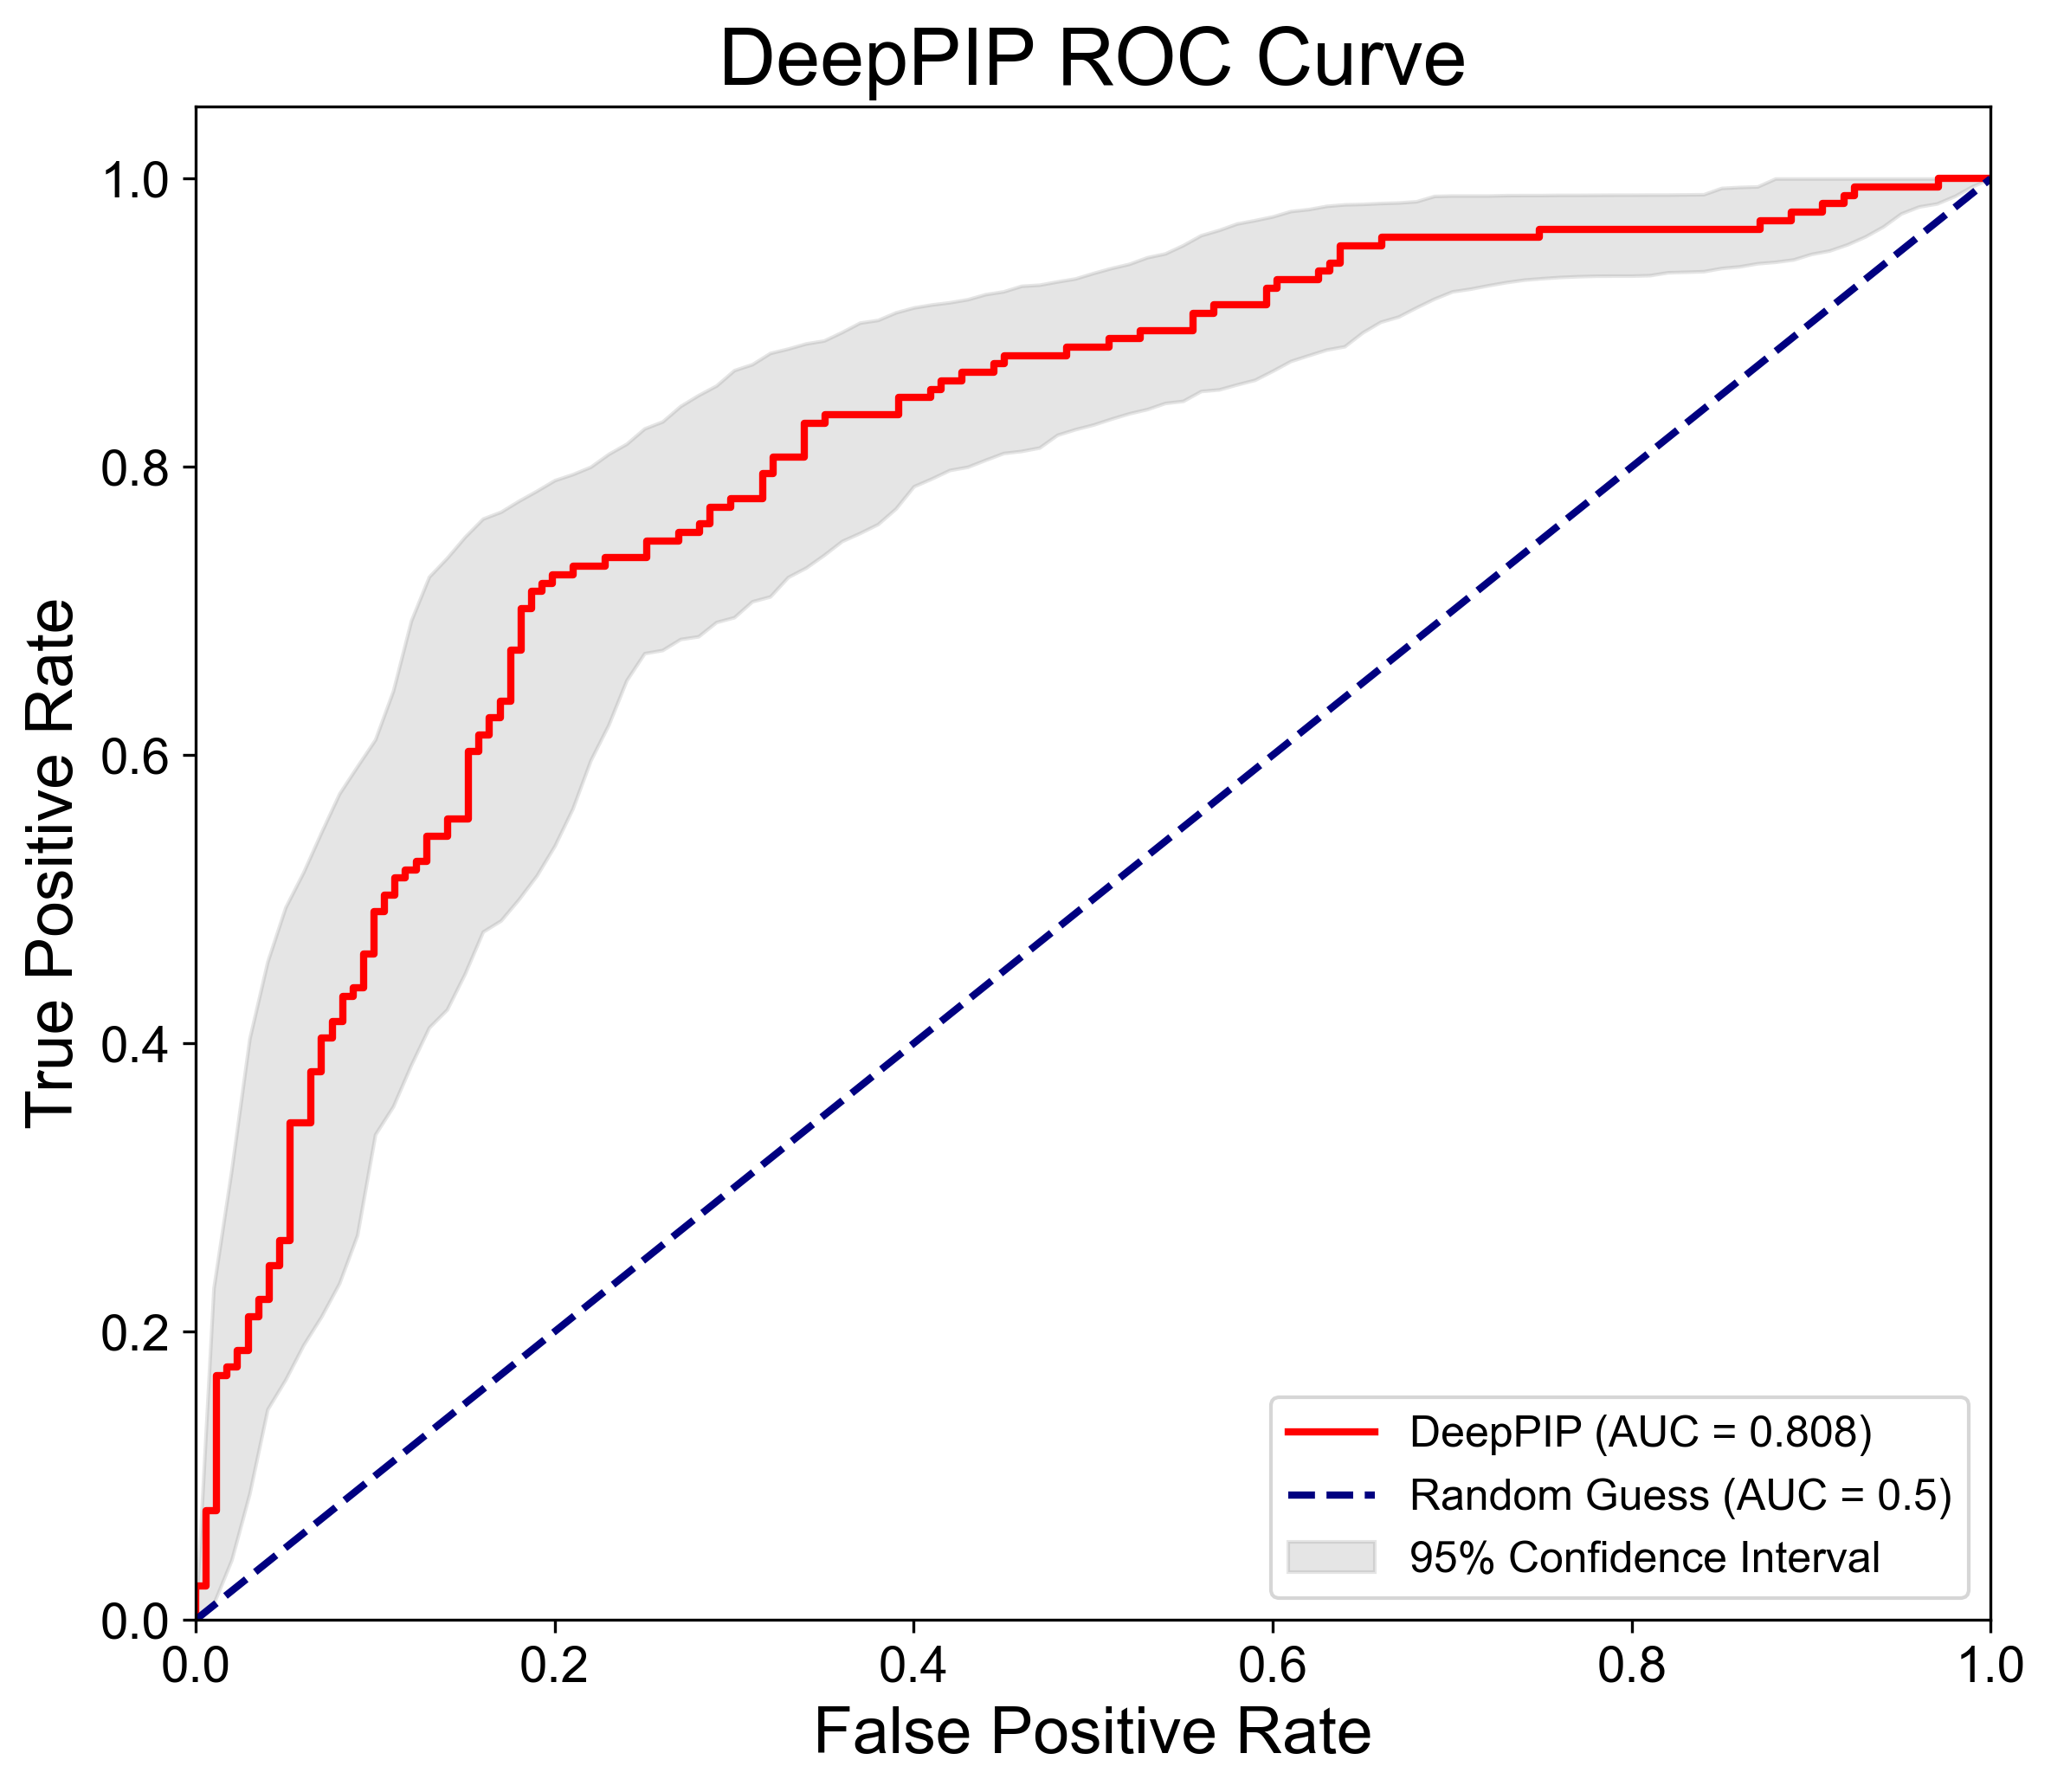


📊 AUC: 0.8080, 95% CI: [0.7597, 0.8537]


In [29]:
# ============================================================
# 绘制带置信区间的ROC曲线 (使用 Unicode 上标)
# ============================================================
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def set_seed(seed):
    np.random.seed(seed)

def plot_roc_with_ci(y_true, y_score, model_name="Stacking Model", n_bootstraps=1000, alpha=0.95, random_state=42,
                     title_fontsize=16, axis_label_fontsize=14, tick_fontsize=12, legend_fontsize=10):
    """
    绘制ROC曲线并计算AUC的置信区间，AUC值显示在图例中。
    """
    set_seed(random_state)
    
    # 设置全局字体
    plt.rcParams['font.family'] = 'Arial'
    
    # 原始ROC和AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Bootstrapping 计算AUC的置信区间
    bootstrapped_aucs = []
    base_fpr = np.linspace(0, 1, 101)
    tprs = []

    for i in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        y_true_resample = y_true[indices]
        y_score_resample = y_score[indices]

        if len(np.unique(y_true_resample)) < 2:
            continue

        fpr_resample, tpr_resample, _ = roc_curve(y_true_resample, y_score_resample)
        bootstrapped_aucs.append(auc(fpr_resample, tpr_resample))
        
        interp_tpr = np.interp(base_fpr, fpr_resample, tpr_resample)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    # 计算AUC的置信区间
    lower_percentile = (1 - alpha) / 2 * 100
    upper_percentile = (1 + alpha) / 2 * 100
    
    auc_lower_bound = np.percentile(bootstrapped_aucs, lower_percentile)
    auc_upper_bound = np.percentile(bootstrapped_aucs, upper_percentile)

    # 计算TPR置信带
    tprs_lower = np.percentile(tprs, lower_percentile, axis=0)
    tprs_upper = np.percentile(tprs, upper_percentile, axis=0)

    # 绘图
    fig, ax = plt.subplots(figsize=(8, 7), dpi=300)
    
    # 绘制ROC曲线
    ax.plot(fpr, tpr, color='red', lw=2,
            label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # 绘制置信区间带
    ax.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                    label=f'{int(alpha*100)}% Confidence Interval')

    # 绘制对角线
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    
    # 设置坐标轴范围
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    # 设置坐标轴标签
    ax.set_xlabel('False Positive Rate', fontsize=axis_label_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=axis_label_fontsize)
    
    # 设置标题
    ax.set_title(f'{model_name} ROC Curve', fontsize=title_fontsize)
    
    # 设置刻度值字体大小
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # 设置图例
    ax.legend(loc="lower right", fontsize=legend_fontsize-2)
    
    # 关闭网格
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()

    print(f"\n📊 AUC: {roc_auc:.4f}, 95% CI: [{auc_lower_bound:.4f}, {auc_upper_bound:.4f}]")
    
    return roc_auc, auc_lower_bound, auc_upper_bound


# ============================================================
# 调用 - 使用 Unicode 上标 ᵃ
# ============================================================
roc_auc, auc_lower, auc_upper = plot_roc_with_ci(
    y_test, 
    y_test_pred_proba[:, 1], 
    # model_name='BiLSTMᵃ+Transformer',  # 使用 Unicode 上标 ᵃ
    model_name='DeepPIP',
    n_bootstraps=1000,
    alpha=0.95,
    random_state=42,
    title_fontsize=22,
    axis_label_fontsize=18,
    tick_fontsize=14,
    legend_fontsize=14
)

### 有无Transformer模块

训练集: (2872, 1009)
测试集: (342, 1009)
特征范围: [-9.25, 18.80]
设备: cuda
🔬 消融实验：验证Transformer模块有效性
实验设置:
  - 基模型: MLP + BiLSTM (相同)
  - 元模型对比:
    📌 实验1: 简单分类头 (无Transformer)
    📌 实验2: 完整Transformer (有自注意力)


📌 实验1: 无Transformer（简单分类头）

训练中...
🔧 Training MLP...
   Early stopping at epoch 37, best val_loss: 0.5911
✅ MLP done! Best val_loss: 0.5911

🔧 Training BiLSTM...
   Early stopping at epoch 38, best val_loss: 0.5947
✅ BiLSTM done! Best val_loss: 0.5947

🔧 Training MLP...
   Early stopping at epoch 33, best val_loss: 0.5805
✅ MLP done! Best val_loss: 0.5805

🔧 Training MLP...
   Early stopping at epoch 33, best val_loss: 0.6140
✅ MLP done! Best val_loss: 0.6140

🔧 Training MLP...
   Early stopping at epoch 32, best val_loss: 0.6284
✅ MLP done! Best val_loss: 0.6284

🔧 Training MLP...
   Early stopping at epoch 35, best val_loss: 0.5830
✅ MLP done! Best val_loss: 0.5830

🔧 Training MLP...
   Early stopping at epoch 33, best val_loss: 0.5932
✅ MLP done! Best val_loss: 0.5932

🔧 Training BiLS

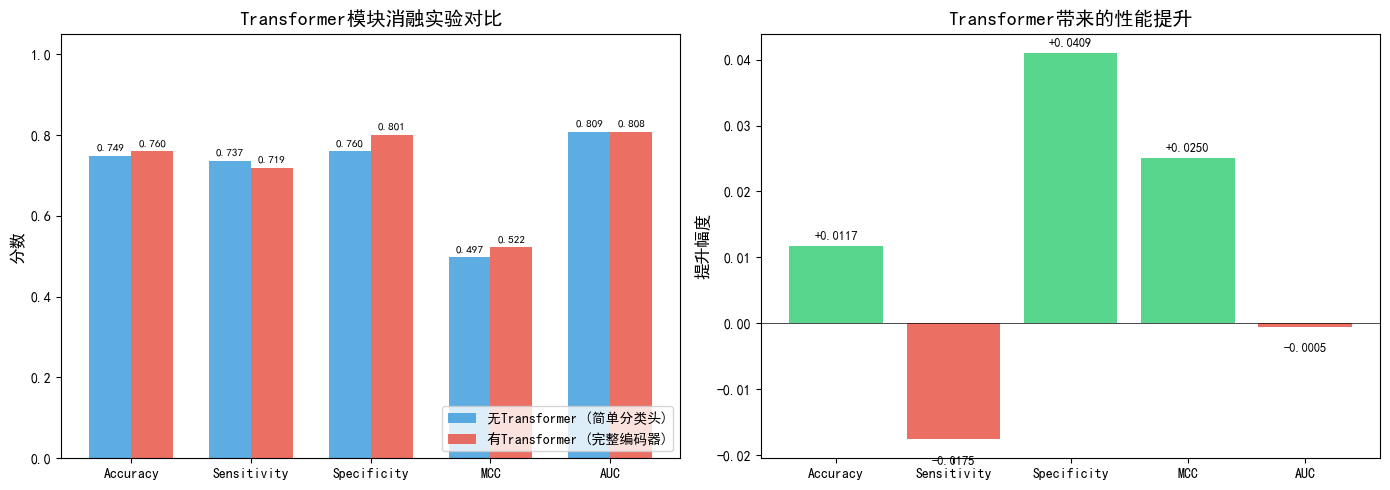


✅ 消融实验结果已保存为 'transformer_ablation_study.png'


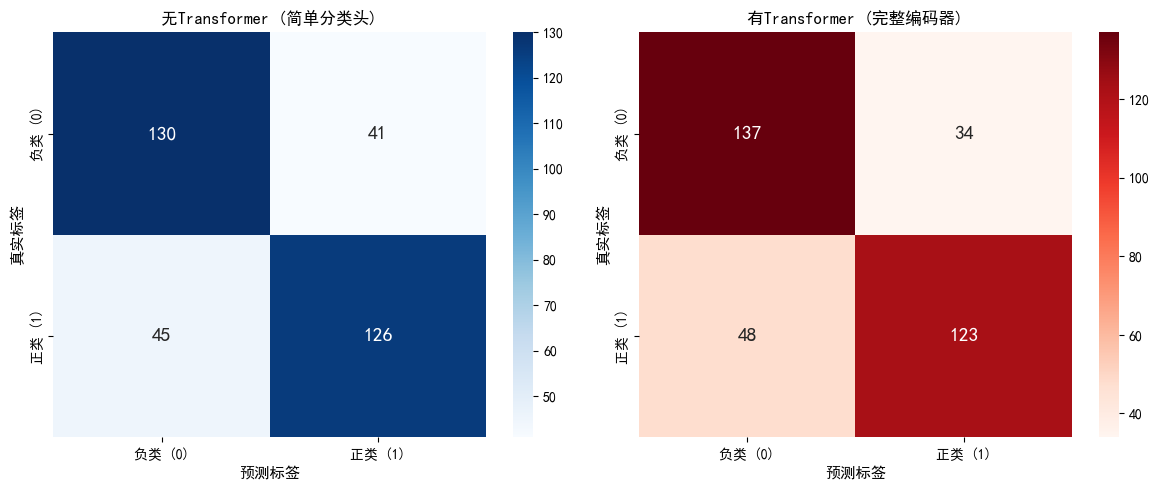

✅ 混淆矩阵对比已保存为 'confusion_matrix_comparison.png'

📋 消融实验总结

模型架构说明:

【无Transformer - 简单分类头】
  输入 → Linear(in_dim, 32) → LayerNorm → ReLU → Dropout → Linear(32, 2) → 输出

【有Transformer - 完整编码器】
  输入 → Linear(in_dim, 32) → LayerNorm 
       → MultiheadAttention (4头) + 残差连接 + LayerNorm
       → FFN (32→64→32) + 残差连接 + LayerNorm
       → Linear(32, 2) → 输出

性能对比:
  - Accuracy:    0.7485 → 0.7602 (+0.0117)
  - Sensitivity: 0.7368 → 0.7193 (-0.0175)
  - Specificity: 0.7602 → 0.8012 (+0.0409)
  - MCC:         0.4972 → 0.5222 (+0.0250)
  - AUC:         0.8086 → 0.8080 (-0.0005)

🎯 结论: Transformer的自注意力机制能够更好地融合基模型的预测信息，提升集成效果！


In [5]:
# 修改后的代码：MLP + BiLSTM 为基模型，验证Transformer元模型有效性

import os
import math
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ============================================================
# 1. 固定所有随机种子（最重要！）
# ============================================================
def set_seed(seed=42):
    """固定所有随机种子，确保可复现"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# 清理GPU内存
torch.cuda.empty_cache()
gc.collect()

# ============================================================
# 2. 加载数据
# ============================================================
os.chdir('G:\lhy\work')

X_new = pd.read_csv(r'G:\lhy\work\train_feature\feature\ESMC300+PAAC+APAAC.csv', header=None)
y_new = pd.read_csv(r'data/label_train.csv', header=None)
X_new1 = pd.read_csv(r"G:\lhy\work\test_feature\ESMC300+PAAC+APAAC.csv", header=None)
y_new1 = pd.read_csv(r'data/label_test.csv', header=None)


X_train = np.array(X_new)
y_train = np.array(y_new).ravel()
X_test = np.array(X_new1)
y_test = np.array(y_new1).ravel()

# ============================================================
# 3. 特征标准化（关键！）
# ============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"训练集: {X_train.shape}")
print(f"测试集: {X_test.shape}")
print(f"特征范围: [{X_train.min():.2f}, {X_train.max():.2f}]")

input_dim = X_train.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"设备: {device}")

# ============================================================
# 4. 简单 MLP 模型（基模型）
# ============================================================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64), output_dim=2, dropout=0.3, use_bn=False):
        super().__init__()
        self.use_bn = use_bn
        
        if isinstance(hidden_dims, int):
            hidden_dims = (hidden_dims,)
        
        layers = []
        prev_dim = input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_bn:
                layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ============================================================
# 5. BiLSTM 模型（基模型）
# ============================================================
class BiLSTMWithSimpleAttention(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.3):
        super().__init__()
        
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        self.input_proj = nn.Sequential(
            nn.Linear(in_dim, seq_len * hidden_dim),
            nn.LayerNorm(seq_len * hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        
        self.ln1 = nn.LayerNorm(hidden_dim * 2)
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden_dim * 2)
        
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim * 2)
        )
        self.ln3 = nn.LayerNorm(hidden_dim * 2)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 2)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.input_proj(x)
        x = x.view(batch_size, self.seq_len, self.hidden_dim)
        
        lstm_out, (h_n, _) = self.bilstm(x)
        
        forward_hidden = h_n[-2, :, :]
        backward_hidden = h_n[-1, :, :]
        hidden = torch.cat([forward_hidden, backward_hidden], dim=1)
        
        hidden = self.ln1(hidden)
        hidden = hidden.unsqueeze(1)
        
        attn_out, _ = self.self_attention(hidden, hidden, hidden)
        hidden = self.ln2(hidden + attn_out)
        
        hidden = self.ln3(hidden + self.ffn(hidden))
        hidden = hidden.squeeze(1)
        
        return self.classifier(hidden)

# ============================================================
# 6. 【新增】简单分类头模型（无Transformer - 消融对照）
# ============================================================
class SimpleClassifierHead(nn.Module):
    """
    简单分类头：只有线性层，没有Transformer编码器
    用于消融实验，对比Transformer的有效性
    """
    def __init__(self, in_dim, hidden_dim=32, dropout=0.3):
        super().__init__()
        
        # 只有简单的MLP分类头，没有任何注意力机制
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)  # 输出2个类别
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        return self.classifier(x)

# ============================================================
# 7. 【完整】Transformer 元模型（有Transformer编码器）
# ============================================================
class TorchTransformer(nn.Module):
    """
    完整Transformer：包含自注意力编码器 + 分类头
    """
    def __init__(self, in_dim, hidden_dim=32, num_heads=4, dropout=0.3):
        super().__init__()
        
        # 输入投影
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        
        # ⭐ Transformer核心：多头自注意力
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=num_heads,
            dropout=dropout, 
            batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden_dim)
        
        # ⭐ Transformer核心：前馈网络
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.ln3 = nn.LayerNorm(hidden_dim)
        
        # 分类头
        self.classifier = nn.Linear(hidden_dim, 2)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        # 输入投影 + LayerNorm
        x = self.ln1(self.input_proj(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        
        # ⭐ 自注意力 + 残差连接
        attn_out, _ = self.attention(x, x, x)
        x = self.ln2(x + attn_out)
        
        # ⭐ 前馈网络 + 残差连接
        x = self.ln3(x + self.ffn(x))
        
        x = x.squeeze(1)  # (batch, hidden_dim)
        return self.classifier(x)

# ============================================================
# 8. MLP 分类器（基模型）
# ============================================================
class TorchMLPClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, in_dim, hidden_dim=128, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)
        )
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            worker_init_fn=lambda _: set_seed(self.random_state)
        )
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        self.model = SimpleMLP(
            input_dim=self.in_dim,
            hidden_dims=(self.hidden_dim, self.hidden_dim // 2),
            output_dim=2,
            dropout=self.dropout,
            use_bn=False
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training MLP...")
        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ MLP done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def decision_function(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 9. BiLSTM 分类器（基模型）
# ============================================================
class TorchBiLSTMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, in_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)
        )
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            worker_init_fn=lambda _: set_seed(self.random_state)
        )
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        self.model = BiLSTMWithSimpleAttention(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            seq_len=self.seq_len,
            num_heads=self.num_heads,
            dropout=self.dropout
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training BiLSTM...")
        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ BiLSTM done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def decision_function(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 10. 【新增】简单分类头元模型（无Transformer - 消融对照）
# ============================================================
class SimpleMetaClassifier(BaseEstimator, ClassifierMixin):
    """
    简单元分类器：只有线性分类头，没有Transformer
    用于消融实验对比
    """
    
    def __init__(self, hidden_dim=32, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.in_dim = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        self.in_dim = X.shape[1]
        
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)
        )
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        # ⭐ 使用简单分类头，无Transformer
        self.model = SimpleClassifierHead(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            dropout=self.dropout
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training Simple Meta Classifier (NO Transformer)...")
        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ Simple Meta done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# ============================================================
# 11. Transformer 元模型分类器（完整版）
# ============================================================
class TorchTransformerMetaClassifier(BaseEstimator, ClassifierMixin):
    """
    完整Transformer元分类器：包含自注意力编码器
    """
    
    def __init__(self, hidden_dim=32, num_heads=4, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.in_dim = None
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        set_seed(self.random_state)
        self.in_dim = X.shape[1]
        
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=0.15, random_state=self.random_state, stratify=y
        )
        
        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.long)
        )
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(self.device)
        
        # ⭐ 使用完整Transformer
        self.model = TorchTransformer(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            num_heads=self.num_heads,
            dropout=self.dropout
        ).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None
        
        if self.verbose:
            print(f"🔧 Training Transformer Meta Model (WITH Transformer)...")
        
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
            
            train_loss /= len(train_dataset)
            
            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"   Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}")
                    break
            
            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"   Epoch {epoch+1}, Train: {train_loss:.4f}, Val: {val_loss:.4f}")
        
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)
        
        if self.verbose:
            print(f"✅ Transformer Meta done! Best val_loss: {best_val_loss:.4f}\n")
        
        return self
    
    def predict_proba(self, X):
        self.model.eval()
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_proba = []
        with torch.no_grad():
            for (batch_X,) in loader:
                batch_X = batch_X.to(self.device)
                logits = self.model(batch_X)
                proba = torch.softmax(logits, dim=1).cpu().numpy()
                all_proba.append(proba)
        
        return np.vstack(all_proba)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# ============================================================
# 12. WithDecision 包装器
# ============================================================
class WithDecision(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        self.classes_ = self.estimator.classes_
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def decision_function(self, X):
        proba = self.estimator.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 13. 评估函数
# ============================================================
def evaluate_model(y_true, y_pred, y_pred_proba):
    """计算所有评估指标"""
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    mcc = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) + 1e-10)
    auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    
    return {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'MCC': mcc,
        'AUC': auc,
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
    }

# ============================================================
# 14. 消融实验：对比有/无Transformer
# ============================================================
print("=" * 70)
print("🔬 消融实验：验证Transformer模块有效性")
print("=" * 70)
print("实验设置:")
print("  - 基模型: MLP + BiLSTM (相同)")
print("  - 元模型对比:")
print("    📌 实验1: 简单分类头 (无Transformer)")
print("    📌 实验2: 完整Transformer (有自注意力)")
print("=" * 70)
print()

# 存储结果
results = {}

# ============================================================
# 实验1: 无Transformer（只有简单分类头）
# ============================================================
print("\n" + "=" * 70)
print("📌 实验1: 无Transformer（简单分类头）")
print("=" * 70 + "\n")

set_seed(42)  # 重置随机种子

base_models_exp1 = [
    ('mlp', WithDecision(TorchMLPClassifier(
        in_dim=input_dim, hidden_dim=128, dropout=0.3,
        epochs=200, lr=5e-4, batch_size=32, patience=30,
        verbose=True, random_state=42
    ))),
    ('bilstm', WithDecision(TorchBiLSTMClassifier(
        in_dim=input_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.5,
        epochs=200, lr=5e-4, batch_size=32, patience=30,
        verbose=True, random_state=42
    )))
]

# 无Transformer的简单分类头
meta_model_simple = SimpleMetaClassifier(
    hidden_dim=32, dropout=0.3,
    epochs=200, lr=5e-4, batch_size=32, patience=30,
    verbose=True, random_state=42
)

stacking_no_transformer = StackingClassifier(
    estimators=base_models_exp1,
    final_estimator=meta_model_simple,
    passthrough=True,
    stack_method='predict_proba',
    cv=5
)

print("训练中...")
stacking_no_transformer.fit(X_train, y_train)

# 评估
y_pred_proba_no_tf = stacking_no_transformer.predict_proba(X_test)
y_pred_no_tf = np.argmax(y_pred_proba_no_tf, axis=1)
results['无Transformer'] = evaluate_model(y_test, y_pred_no_tf, y_pred_proba_no_tf)

print("\n📊 无Transformer结果:")
for k, v in results['无Transformer'].items():
    if k not in ['TP', 'TN', 'FP', 'FN']:
        print(f"  {k}: {v:.4f}")

# 清理内存
del stacking_no_transformer, base_models_exp1, meta_model_simple
torch.cuda.empty_cache()
gc.collect()

# ============================================================
# 实验2: 有Transformer（完整版）
# ============================================================
print("\n" + "=" * 70)
print("📌 实验2: 有Transformer（完整Transformer编码器）")
print("=" * 70 + "\n")

set_seed(42)  # 重置随机种子

base_models_exp2 = [
    ('mlp', WithDecision(TorchMLPClassifier(
        in_dim=input_dim, hidden_dim=128, dropout=0.3,
        epochs=200, lr=5e-4, batch_size=32, patience=30,
        verbose=True, random_state=42
    ))),
    ('bilstm', WithDecision(TorchBiLSTMClassifier(
        in_dim=input_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.5,
        epochs=200, lr=5e-4, batch_size=32, patience=30,
        verbose=True, random_state=42
    )))
]

# 完整Transformer元模型
meta_model_transformer = TorchTransformerMetaClassifier(
    hidden_dim=32, num_heads=4, dropout=0.3,
    epochs=200, lr=5e-4, batch_size=32, patience=30,
    verbose=True, random_state=42
)

stacking_with_transformer = StackingClassifier(
    estimators=base_models_exp2,
    final_estimator=meta_model_transformer,
    passthrough=True,
    stack_method='predict_proba',
    cv=5
)

print("训练中...")
stacking_with_transformer.fit(X_train, y_train)

# 评估
y_pred_proba_with_tf = stacking_with_transformer.predict_proba(X_test)
y_pred_with_tf = np.argmax(y_pred_proba_with_tf, axis=1)
results['有Transformer'] = evaluate_model(y_test, y_pred_with_tf, y_pred_proba_with_tf)

print("\n📊 有Transformer结果:")
for k, v in results['有Transformer'].items():
    if k not in ['TP', 'TN', 'FP', 'FN']:
        print(f"  {k}: {v:.4f}")

# ============================================================
# 15. 结果对比与可视化
# ============================================================
print("\n" + "=" * 70)
print("🎯 消融实验结果对比")
print("=" * 70)

# 创建对比表格
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'AUC']
print(f"\n{'指标':<15} {'无Transformer':<15} {'有Transformer':<15} {'提升':<15}")
print("-" * 60)

improvements = {}
for metric in metrics:
    no_tf = results['无Transformer'][metric]
    with_tf = results['有Transformer'][metric]
    diff = with_tf - no_tf
    improvements[metric] = diff
    
    sign = "+" if diff > 0 else ""
    print(f"{metric:<15} {no_tf:<15.4f} {with_tf:<15.4f} {sign}{diff:.4f}")

print("-" * 60)

# 判断Transformer是否有效
avg_improvement = sum(improvements.values()) / len(improvements)
print(f"\n平均提升: {avg_improvement:+.4f}")

if avg_improvement > 0.005:
    print("\n✅ 结论: Transformer模块有效！带来了性能提升。")
elif avg_improvement < -0.005:
    print("\n❌ 结论: Transformer模块无效。简单分类头效果更好。")
else:
    print("\n⚠️ 结论: Transformer模块效果不明显，两者性能相近。")

# ============================================================
# 16. 可视化对比
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 柱状图对比
ax1 = axes[0]
x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, [results['无Transformer'][m] for m in metrics], 
                width, label='无Transformer (简单分类头)', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, [results['有Transformer'][m] for m in metrics], 
                width, label='有Transformer (完整编码器)', color='#e74c3c', alpha=0.8)

ax1.set_ylabel('分数', fontsize=12)
ax1.set_title('Transformer模块消融实验对比', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=10)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.05)

# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# 提升幅度图
ax2 = axes[1]
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in improvements.values()]
bars3 = ax2.bar(metrics, list(improvements.values()), color=colors, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('提升幅度', fontsize=12)
ax2.set_title('Transformer带来的性能提升', fontsize=14)

# 添加数值标签
for bar, val in zip(bars3, improvements.values()):
    height = bar.get_height()
    ax2.annotate(f'{val:+.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3 if height > 0 else -12), textcoords="offset points", 
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('transformer_ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 消融实验结果已保存为 'transformer_ablation_study.png'")

# ============================================================
# 17. 混淆矩阵对比
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 无Transformer混淆矩阵
cm1 = confusion_matrix(y_test, y_pred_no_tf)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['负类 (0)', '正类 (1)'],
            yticklabels=['负类 (0)', '正类 (1)'],
            annot_kws={'size': 14})
axes[0].set_xlabel('预测标签', fontsize=11)
axes[0].set_ylabel('真实标签', fontsize=11)
axes[0].set_title('无Transformer (简单分类头)', fontsize=12)

# 有Transformer混淆矩阵
cm2 = confusion_matrix(y_test, y_pred_with_tf)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['负类 (0)', '正类 (1)'],
            yticklabels=['负类 (0)', '正类 (1)'],
            annot_kws={'size': 14})
axes[1].set_xlabel('预测标签', fontsize=11)
axes[1].set_ylabel('真实标签', fontsize=11)
axes[1].set_title('有Transformer (完整编码器)', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 混淆矩阵对比已保存为 'confusion_matrix_comparison.png'")

# ============================================================
# 18. 最终总结
# ============================================================
print("\n" + "=" * 70)
print("📋 消融实验总结")
print("=" * 70)
print(f"""
模型架构说明:

【无Transformer - 简单分类头】
  输入 → Linear(in_dim, 32) → LayerNorm → ReLU → Dropout → Linear(32, 2) → 输出

【有Transformer - 完整编码器】
  输入 → Linear(in_dim, 32) → LayerNorm 
       → MultiheadAttention (4头) + 残差连接 + LayerNorm
       → FFN (32→64→32) + 残差连接 + LayerNorm
       → Linear(32, 2) → 输出

性能对比:
  - Accuracy:    {results['无Transformer']['Accuracy']:.4f} → {results['有Transformer']['Accuracy']:.4f} ({improvements['Accuracy']:+.4f})
  - Sensitivity: {results['无Transformer']['Sensitivity']:.4f} → {results['有Transformer']['Sensitivity']:.4f} ({improvements['Sensitivity']:+.4f})
  - Specificity: {results['无Transformer']['Specificity']:.4f} → {results['有Transformer']['Specificity']:.4f} ({improvements['Specificity']:+.4f})
  - MCC:         {results['无Transformer']['MCC']:.4f} → {results['有Transformer']['MCC']:.4f} ({improvements['MCC']:+.4f})
  - AUC:         {results['无Transformer']['AUC']:.4f} → {results['有Transformer']['AUC']:.4f} ({improvements['AUC']:+.4f})
""")

if avg_improvement > 0.005:
    print("🎯 结论: Transformer的自注意力机制能够更好地融合基模型的预测信息，提升集成效果！")
elif avg_improvement < -0.005:
    print("🎯 结论: 简单的线性分类头已足够，Transformer可能导致过拟合。")
else:
    print("🎯 结论: 两种方法效果相近，Transformer的复杂度未带来明显收益。")

print("=" * 70)

### MLP + Transformer 为基模型，BiLSTM 为元模型

In [19]:
import os
import math
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ============================================================
# 1. 固定所有随机种子
# ============================================================
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
torch.cuda.empty_cache()
gc.collect()

# ============================================================
# 2. 加载数据
# ============================================================
os.chdir('G:\\lhy\\work')

X_new = pd.read_csv(r'G:\lhy\work\train_feature\feature\ESMC300+PAAC+APAAC.csv', header=None)
y_new = pd.read_csv(r'data/label_train.csv', header=None)
X_new1 = pd.read_csv(r"G:\lhy\work\test_feature\ESMC300+PAAC+APAAC.csv", header=None)
y_new1 = pd.read_csv(r'data/label_test.csv', header=None)

X_train = np.array(X_new)
y_train = np.array(y_new).ravel()
X_test = np.array(X_new1)
y_test = np.array(y_new1).ravel()

# ============================================================
# 3. 特征标准化
# ============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"训练集: {X_train.shape}")
print(f"测试集: {X_test.shape}")

input_dim = X_train.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"设备: {device}")

# ============================================================
# 4. 简单 MLP 模型（修复版 - 使用 LayerNorm）✅
# ============================================================
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # ✅ 使用 LayerNorm 代替 BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),  # ✅ 使用 LayerNorm 代替 BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# ============================================================
# 5. Transformer 模型（基模型）
# ============================================================
class TorchTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, num_heads=4, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=num_heads,
            dropout=dropout, batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.ln1(self.input_proj(x))
        x = x.unsqueeze(1)
        attn_out, _ = self.attention(x, x, x)
        x = self.ln2(x + attn_out)
        x = self.ln3(x + self.ffn(x))
        x = x.squeeze(1)
        return self.classifier(x)

# ============================================================
# 6. BiLSTM 元模型（修复版 - 处理小 batch）✅
# ============================================================
class BiLSTMWithSimpleAttention(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.3):
        super().__init__()

        self.seq_len = seq_len
        self.hidden_dim = hidden_dim

        self.input_proj = nn.Sequential(
            nn.Linear(in_dim, seq_len * hidden_dim),
            nn.LayerNorm(seq_len * hidden_dim),  # ✅ 使用 LayerNorm
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if dropout > 0 else 0  # ✅ 确保 dropout 有效
        )

        self.ln1 = nn.LayerNorm(hidden_dim * 2)
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden_dim * 2)

        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim * 2)
        )
        self.ln3 = nn.LayerNorm(hidden_dim * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.input_proj(x)
        x = x.view(batch_size, self.seq_len, self.hidden_dim)

        lstm_out, (h_n, _) = self.bilstm(x)

        forward_hidden = h_n[-2, :, :]
        backward_hidden = h_n[-1, :, :]
        hidden = torch.cat([forward_hidden, backward_hidden], dim=1)

        hidden = self.ln1(hidden)
        hidden = hidden.unsqueeze(1)

        attn_out, _ = self.self_attention(hidden, hidden, hidden)
        hidden = self.ln2(hidden + attn_out)

        hidden = self.ln3(hidden + self.ffn(hidden))
        hidden = hidden.squeeze(1)

        return self.classifier(hidden)

# ============================================================
# 7. MLP 分类器（修复版）✅
# ============================================================
class TorchMLPClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, in_dim, hidden_dim=128, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        set_seed(self.random_state)

        # ✅ 确保有足够的样本进行划分
        if len(X) < 10:
            X_tr, X_val, y_tr, y_val = X, X, y, y
        else:
            X_tr, X_val, y_tr, y_val = train_test_split(
                X, y, test_size=0.15, random_state=self.random_state, stratify=y
            )

        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1)
        )
        
        # ✅ 动态调整 batch_size，确保不会出现 batch_size=1
        effective_batch_size = min(self.batch_size, len(train_dataset))
        if effective_batch_size < 2:
            effective_batch_size = len(train_dataset)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=effective_batch_size, 
            shuffle=True,
            drop_last=(len(train_dataset) > effective_batch_size)  # ✅ 丢弃最后的小 batch
        )

        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(self.device)

        self.model = SimpleMLP(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            dropout=self.dropout
        ).to(self.device)

        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )

        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)

            train_loss /= len(train_dataset)

            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()

            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break

        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)

        return self

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            proba = self.model(X_tensor).cpu().numpy()

        return np.hstack([1 - proba, proba])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def decision_function(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 8. Transformer 分类器（修复版）✅
# ============================================================
class TorchTransformerClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, in_dim, hidden_dim=32, num_heads=4, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        set_seed(self.random_state)

        if len(X) < 10:
            X_tr, X_val, y_tr, y_val = X, X, y, y
        else:
            X_tr, X_val, y_tr, y_val = train_test_split(
                X, y, test_size=0.15, random_state=self.random_state, stratify=y
            )

        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1)
        )
        
        effective_batch_size = min(self.batch_size, len(train_dataset))
        if effective_batch_size < 2:
            effective_batch_size = len(train_dataset)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=effective_batch_size, 
            shuffle=True,
            drop_last=(len(train_dataset) > effective_batch_size)
        )

        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(self.device)

        self.model = TorchTransformer(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            num_heads=self.num_heads,
            dropout=self.dropout
        ).to(self.device)

        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )

        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)

            train_loss /= len(train_dataset)

            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()

            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break

        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)

        return self

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            proba = self.model(X_tensor).cpu().numpy()

        return np.hstack([1 - proba, proba])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def decision_function(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 9. BiLSTM 元模型分类器（修复版）✅
# ============================================================
class TorchBiLSTMMetaClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, hidden_dim=64, seq_len=10, num_heads=4, dropout=0.3, 
                 epochs=200, lr=5e-4, batch_size=32, patience=30,
                 device=None, verbose=True, random_state=42):
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.dropout = dropout
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.in_dim = None
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        set_seed(self.random_state)
        self.in_dim = X.shape[1]

        if len(X) < 10:
            X_tr, X_val, y_tr, y_val = X, X, y, y
        else:
            X_tr, X_val, y_tr, y_val = train_test_split(
                X, y, test_size=0.15, random_state=self.random_state, stratify=y
            )

        train_dataset = TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1)
        )
        
        effective_batch_size = min(self.batch_size, len(train_dataset))
        if effective_batch_size < 2:
            effective_batch_size = len(train_dataset)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=effective_batch_size, 
            shuffle=True,
            drop_last=(len(train_dataset) > effective_batch_size)
        )

        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(self.device)
        y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(self.device)

        self.model = BiLSTMWithSimpleAttention(
            self.in_dim, 
            hidden_dim=self.hidden_dim,
            seq_len=self.seq_len,
            num_heads=self.num_heads,
            dropout=self.dropout
        ).to(self.device)

        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, verbose=False
        )

        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                pred = self.model(batch_X)
                loss = criterion(pred, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)

            train_loss /= len(train_dataset)

            self.model.eval()
            with torch.no_grad():
                val_pred = self.model(X_val_t)
                val_loss = criterion(val_pred, y_val_t).item()

            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break

        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(self.device)

        return self

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            proba = self.model(X_tensor).cpu().numpy()

        return np.hstack([1 - proba, proba])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# ============================================================
# 10. WithDecision 包装器
# ============================================================
class WithDecision(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        self.estimator.fit(X, y)
        self.classes_ = self.estimator.classes_
        return self

    def predict(self, X):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def decision_function(self, X):
        proba = self.estimator.predict_proba(X)
        return proba[:, 1] - proba[:, 0]

# ============================================================
# 11. 创建模型并训练
# ============================================================
print("=" * 60)
print("初始化修复版模型...")
print("=" * 60)

base_models = [
    ('mlp', WithDecision(TorchMLPClassifier(
        in_dim=input_dim,
        hidden_dim=128,
        dropout=0.3,
        epochs=200,
        lr=5e-4,
        batch_size=32,
        patience=30,
        verbose=False,  # ✅ 减少输出
        random_state=42
    ))),
    
    ('transformer', WithDecision(TorchTransformerClassifier(
        in_dim=input_dim,
        hidden_dim=32,
        num_heads=4,
        dropout=0.3,
        epochs=200,
        lr=5e-4,
        batch_size=32,
        patience=30,
        verbose=False,
        random_state=42
    )))
]

meta_model = TorchBiLSTMMetaClassifier(
    hidden_dim=64,
    seq_len=10,
    num_heads=4,
    dropout=0.3,
    epochs=200,
    lr=5e-4,
    batch_size=32,
    patience=30,
    verbose=False,
    random_state=42
)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    stack_method='predict_proba',
    cv=5  # ✅ 明确指定 CV 折数
)

print("\n训练 Stacking 模型...")
stacking_model.fit(X_train, y_train)

# ============================================================
# 12. 评估
# ============================================================
print("\n" + "=" * 60)
print("在独立测试集上评估...")
print("=" * 60)

y_test_pred_proba = stacking_model.predict_proba(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

TN, FP, FN, TP = confusion_matrix(y_test, y_test_pred).ravel()

test_accuracy = (TP + TN) / (TP + TN + FP + FN)
test_sensitivity = TP / (TP + FN)
test_specificity = TN / (TN + FP)
test_mcc = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) + 1e-10)
test_auc = roc_auc_score(y_test, y_test_pred_proba[:, 1])

print(f"Accuracy:    {test_accuracy:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"MCC:         {test_mcc:.4f}")
print(f"AUC:         {test_auc:.4f}")
print("=" * 60)

训练集: (2872, 1009)
测试集: (342, 1009)
设备: cuda
初始化修复版模型...

训练 Stacking 模型...

在独立测试集上评估...
Accuracy:    0.7281
Sensitivity: 0.7368
Specificity: 0.7193
MCC:         0.4562
AUC:         0.7890
